Libraries

In [136]:
#importing libraries
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
import joblib
nltk.download('stopwords')
nltk.download('wordnet')
import warnings

[nltk_data] Downloading package stopwords to C:\Users\Saim
[nltk_data]     Khalid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Saim
[nltk_data]     Khalid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [137]:
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pandas")

loading dataset

In [138]:
df=pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1')
labels=['target','ids','date','flag','user','text']
df=pd.read_csv("training.1600000.processed.noemoticon.csv",names=labels, encoding='ISO-8859-1')
df.sample(2)

,target,ids,date,flag,user,text
40772,0,1573871389,Tue Apr 21 03:15:03 PDT 2009,NO_QUERY,miss_soylatte,is not in a good mood
18681,0,1556664201,Sat Apr 18 23:46:49 PDT 2009,NO_QUERY,mslujan,hEaDeD hOmE. LoNg dRiVe


In [139]:
df.shape

(1600000, 6)

**Dataset cleaning**

In [140]:
df.index

RangeIndex(start=0, stop=1600000, step=1)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [142]:
df['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

In [143]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

Removing duplicates and null values

In [144]:
# Checking duplicates and null values
print("\nChecking for duplicates:")
print(f"Number of duplicates: {df.duplicated().sum()}")

print("\nChecking for null values:")
print(f"Number of null values:\n{df.isnull().sum()}")

# Removing duplicates and null values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


Checking for duplicates:
Number of duplicates: 0

Checking for null values:
Number of null values:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


Balancing each class to reduce time consumption

In [145]:
dfs=df.groupby('target',group_keys=False).apply(lambda x: x.sample(50000))

C:\Users\Saim Khalid\AppData\Local\Temp\ipykernel_8968\620275577.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfs=df.groupby('target',group_keys=False).apply(lambda x: x.sample(50000))


In [146]:
dfs['target'].value_counts()

target
0    50000
4    50000
Name: count, dtype: int64

target values to Categorical values

In [147]:
dfs['target']=['Negative' if x==0 else 'Positive' for x in dfs['target']]
dfs["target"].value_counts()

target
Negative    50000
Positive    50000
Name: count, dtype: int64

**Dataset Preprocessing**

In [148]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [149]:
# Preprocessing function
def pre_process(content):
    # Remove special characters
    process_content = re.sub(r'[^a-zA-Z\s]', "", content)
    process_content = process_content.lower()  # Lowercase the text data
    process_content = process_content.split(' ')  # Splitting to words
    
    #Lemmatization and Stop word removal
    process_content = [lemmatizer.lemmatize(word) for word in process_content if word not in stop_words]
    return " ".join(process_content)

dfs['processed_text'] = dfs['text'].apply(pre_process)

In [150]:
dfs.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text', 'processed_text'], dtype='object')

In [151]:
x=dfs['processed_text']
y=dfs['target']

Splliting for test-train

In [152]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2,stratify=y)

Vectorize the data using TfIdf Vectorizer

In [153]:
vectorizer=TfidfVectorizer()

In [154]:
X_train_vect=vectorizer.fit_transform(X_train)
X_test_vect=vectorizer.transform(X_test)

**Logistic Regression for classification**

In [155]:
# Logistic Regression with GridSearchCV for Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5)
grid_search.fit(X_train_vect, Y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'lbfgs']})

In [156]:
# Best Model and Score
best_model = grid_search.best_estimator_
print("Best parameters: ", grid_search.best_params_)
print("Best Logistic Regression model score: ", grid_search.best_score_)

Best parameters:  {'C': 1, 'solver': 'liblinear'}
Best Logistic Regression model score:  0.7634000000000001


In [157]:
print(f"Logistic Regression Accuracy: {grid_search.best_score_}")


Logistic Regression Accuracy: 0.7634000000000001


In [158]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vect, Y_train)

# Predictions using Random Forest
y_pred_rf = rf_model.predict(X_test_vect)

# Random Forest Accuracy and Confusion Matrix
rf_accuracy = accuracy_score(Y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.752


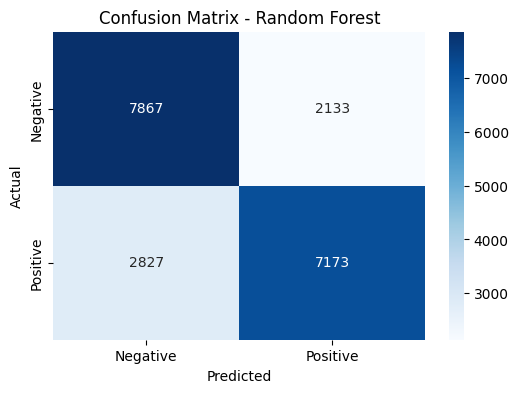

In [159]:
conf_matrix_rf = confusion_matrix(Y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [160]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)


In [161]:
# Voting Classifier - Combine Logistic Regression, Random Forest, and Gradient Boosting
voting_clf = VotingClassifier(estimators=[
    ('lr', best_model),  # Best Logistic Regression from GridSearchCV
    ('rf', rf_model),
    ('gb', gb_model)
], voting='soft')

# Fitting Voting Classifier
voting_clf.fit(X_train_vect, Y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, max_iter=500,
                                                 solver='liblinear')),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [162]:
# Predictions using Voting Classifier
y_pred_voting = voting_clf.predict(X_test_vect)

# Voting Classifier Accuracy and Confusion Matrix
voting_accuracy = accuracy_score(Y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy}")

Voting Classifier Accuracy: 0.7654


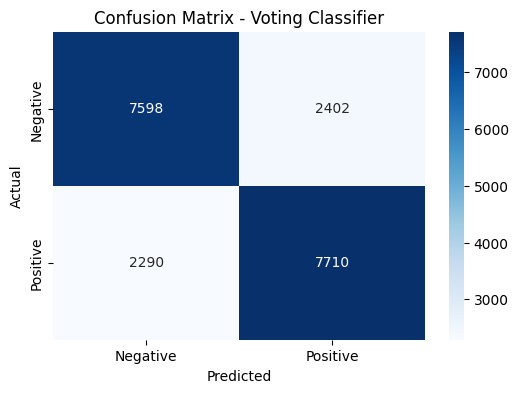

In [163]:
conf_matrix_voting = confusion_matrix(Y_test, y_pred_voting)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_voting, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

In [164]:
# Classification Report - Voting Classifier
print("Classification Report - Voting Classifier:\n", classification_report(Y_test, y_pred_voting))


Classification Report - Voting Classifier:
               precision    recall  f1-score   support

    Negative       0.77      0.76      0.76     10000
    Positive       0.76      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



In [165]:
# Comparison of Accuracies
print(f"Logistic Regression Accuracy: {grid_search.best_score_}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Voting Classifier Accuracy: {voting_accuracy}")

Logistic Regression Accuracy: 0.7634000000000001
Random Forest Accuracy: 0.752
Voting Classifier Accuracy: 0.7654


**Model dump for later use**

In [166]:
joblib.dump(best_model,"dump_sentiment_analysis_logistic_model.joblib")

['dump_sentiment_analysis_logistic_model.joblib']

In [167]:
joblib.dump(vectorizer,"vectorizer_vocabulary.joblib")

['vectorizer_vocabulary.joblib']

In [168]:
#loading "dump_sentiment_analysis_logistic_model.joblib"
sentiment_analysis_logistic_model=joblib.load('dump_sentiment_analysis_logistic_model.joblib')

In [169]:
sentiment_analysis_logistic_model.predict(X_train_vect[3])

array(['Positive'], dtype=object)

In [170]:
vectorize_vocabulary=joblib.load("vectorizer_vocabulary.joblib")

# Testing our model

In [171]:
test_senti=input()

In [172]:
test_senti=vectorize_vocabulary.transform([test_senti])

# Predicted Sentiment

In [173]:
sentiment_analysis_logistic_model.predict(test_senti)[0]

'Negative'